In [57]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

pd.set_option('display.expand_frame_repr', False) 
tickers = ['MASI', 'MSI20', 'ESG10']

In [3]:
def extract_data(file_path):
    return pd.read_excel(file_path)

folder = 'indices/'
ext = '.xls'

In [4]:
close_df = pd.DataFrame()



for ticker in tickers:
    file = folder + ticker + ext
    data = extract_data(file)
    data = data.set_index('Date')

    close_df[ticker] = data['Dernier']

log_returns = np.log(close_df / close_df.shift(1))
log_returns = log_returns.dropna()

In [5]:
portfolio_value = 1_000_000
print(log_returns)

                MASI     MSI20     ESG10
Date                                    
2023-12-28 -0.003834 -0.003905 -0.007972
2023-12-27  0.004750  0.006431  0.005233
2023-12-26 -0.001542 -0.002264 -0.002314
2023-12-25  0.005107  0.005775  0.005795
2023-12-22  0.002870  0.002999  0.001513
...              ...       ...       ...
2023-01-06 -0.009048 -0.008924 -0.009350
2023-01-05  0.032689  0.034588  0.037042
2023-01-04  0.038938  0.037921  0.042805
2023-01-03  0.018222  0.019822  0.015368
2023-01-02  0.007269  0.007584  0.001556

[248 rows x 3 columns]


## Statistics of our samples

In [6]:
from scipy.stats import skew, kurtosis, jarque_bera

statistics = pd.DataFrame(
    index=[
        'Size',
        'Mean',
        'Standard deviation',
        'Skewness',
        'Excess Kurtosis',
        'Jarque-Bera'
    ]
)

for ticker in tickers:
    statistics[ticker] = [
            len(log_returns[ticker]),
            np.mean(log_returns[ticker]),
            np.std(log_returns[ticker]),
            skew(log_returns[ticker]),
            kurtosis(log_returns[ticker], fisher=False),
            jarque_bera(log_returns[ticker])[0]
        ]

print(statistics)

                           MASI       MSI20       ESG10
Size                 248.000000  248.000000  248.000000
Mean                  -0.000490   -0.000582   -0.000454
Standard deviation     0.007713    0.008586    0.008785
Skewness              -0.466091   -0.602006   -0.445500
Excess Kurtosis       12.811867   10.840732   11.066625
Jarque-Bera         1003.797509  650.242761  680.597953


## VaRs Calculs

In [7]:
from scipy.stats import norm,t

confidence_levels = [0.950, 0.975, 0.980, 0.985, 0.990, 0.995, 0.999]
var_ntx = ['var-n','var-t']
col = ['r','b']

tableau_var = pd.DataFrame(index=confidence_levels)

for ticker in tickers:
    std = statistics.loc['Standard deviation', ticker]
    mu = statistics.loc['Mean', ticker]
    rt = log_returns[ticker]
    
    # calcul var_n
    var_n = [ - std * norm.ppf(1-cl) for cl in confidence_levels]
    
    # calcul var_t
    k = np.mean(((rt - mu) / std) ** 2)
    beta = std ** 2 * (k + 3) / (2 * k + 3)
    n = int(6 / k + 4) + 1
    var_t = [- np.sqrt(beta) * t.ppf(1-cl, n) for cl in confidence_levels]
    
    tableau_var[ticker+' var-n'] = var_n
    tableau_var[ticker+' var-t'] = var_t

In [58]:
print(tableau_var.T)

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.012687  0.015117  0.015840  0.016738  0.017943  0.019867  0.023835
MASI var-t   0.012504  0.015371  0.016276  0.017436  0.019066  0.021864  0.028586
MSI20 var-n  0.014123  0.016828  0.017634  0.018632  0.019974  0.022116  0.026533
MSI20 var-t  0.013792  0.016903  0.017879  0.019127  0.020874  0.023851  0.030908
ESG10 var-n  0.014451  0.017219  0.018043  0.019065  0.020438  0.022630  0.027149
ESG10 var-t  0.014242  0.017509  0.018539  0.019861  0.021718  0.024904  0.032561


In [56]:
tab = pd.DataFrame(index=confidence_levels)
#ticker = 'MASI'

for ticker in tickers :
    for v in var_ntx :
        l = []
        for cl in confidence_levels :
            var = tableau_var[ticker+' '+v][cl]
            tab_ec = [x for x in log_returns[ticker] if x < 0 and x < -var]
            l.append(len(tab_ec) / len(log_returns[ticker]))
        tab[ticker+' '+v] = l

print(tab.T)

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.060484  0.036290  0.028226  0.028226  0.008065  0.008065  0.008065
MASI var-t   0.064516  0.032258  0.028226  0.016129  0.008065  0.008065  0.004032
MSI20 var-n  0.064516  0.044355  0.036290  0.032258  0.016129  0.008065  0.008065
MSI20 var-t  0.068548  0.044355  0.036290  0.032258  0.008065  0.008065  0.004032
ESG10 var-n  0.048387  0.032258  0.032258  0.032258  0.024194  0.012097  0.008065
ESG10 var-t  0.056452  0.032258  0.032258  0.028226  0.024194  0.012097  0.004032


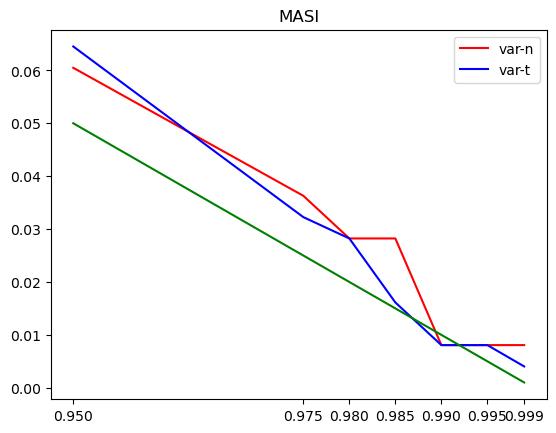

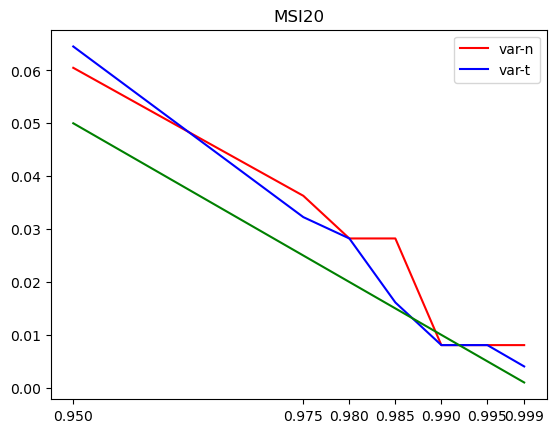

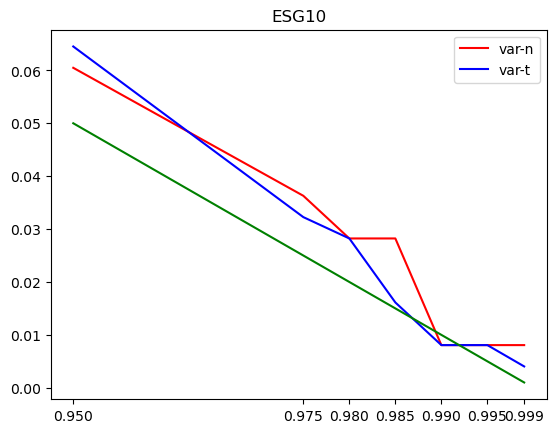

In [59]:
import matplotlib.pyplot as plt

for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tab['MASI '+v],color=c,label=v)

#plt.plot(tab['MASI var-t'],color='b')

    # Repere norme
    y = np.ones(len(confidence_levels))
    y = y - confidence_levels
    plt.plot(confidence_levels,y,color='g')

    plt.xticks(confidence_levels)
    plt.title(ticker)
    plt.legend()
    plt.show()